# Custom Object Detectors

<a href="https://colab.research.google.com/drive/1_yINCuTRs9SYdPXEFTOsxoqQvWbyz1Tq?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

In this notebook, we will desing, inspect and train a custome object detection model: 
1. Backbone 
2. Neck
3. Head





## Setup

In [ ]:
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

Cloning into 'mmdetection'...
remote: Enumerating objects: 23137, done.
remote: Total 23137 (delta 0), reused 0 (delta 0), pack-reused 23137
Receiving objects: 100% (23137/23137), 25.87 MiB | 32.83 MiB/s, done.
Resolving deltas: 100% (16199/16199), done.
/content/mmdetection


In [ ]:
!pip install openmim

  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42503 sha256=fc4b35f26621d15c06cd9be91f6d12f085fc1ea27866d6ecca17dc79771d39c6
  Stored in directory: /root/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
Successfully built openmim


In [ ]:
!mim install mmdet

installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmp9zsi9urb/mmdetection'...
remote: Enumerating objects: 23137, done.
remote: Total 23137 (delta 0), reused 0 (delta 0), pack-reused 23137
Receiving objects: 100% (23137/23137), 25.87 MiB | 32.11 MiB/s, done.
Resolving deltas: 100% (16188/16188), done.
Note: checking out '98949809b7179fab9391663ee5a4ab5978425f90'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

installing dependency: mmcv-full
installing mmcv-full from wheel.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████

In [ ]:
import numpy as np
import os
import pandas as pd
import torch, torchvision
import mmcv
import mmdet
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.datasets import build_dataset
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
from mmcv import Config
from mmdet.apis import inference_detector, init_detector, set_random_seed, show_result_pyplot
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
import os
import os.path as osp
import matplotlib.pyplot as plt

In [ ]:
# Check Pytorch installation
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
print(mmdet.__version__)

# Check mmcv installation
print(get_compiling_cuda_version())
print(get_compiler_version())

1.10.0+cu111 True
2.21.0
11.1
GCC 7.3


## Desing custom model

### Start from a model and update it

In [ ]:
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/yolof/yolof_r50_c5_8x8_1x_coco/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth \
      -O checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth

--2022-02-20 17:06:32--  https://download.openmmlab.com/mmdetection/v2.0/yolof/yolof_r50_c5_8x8_1x_coco/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176992053 (169M) [application/octet-stream]
Saving to: ‘checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth’

checkpoints/yolof_r 100%[===================>] 168.79M  9.78MB/s    in 22s     

2022-02-20 17:06:54 (7.76 MB/s) - ‘checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth’ saved [176992053/176992053]



load checkpoint from local path: checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth


/content/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


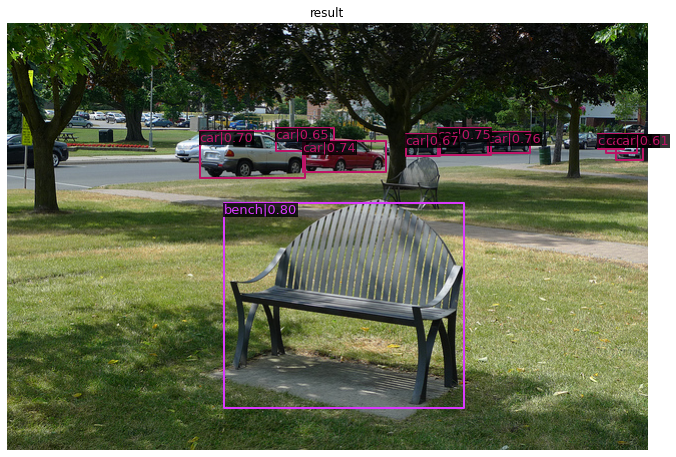

In [ ]:
config = 'configs/yolof/yolof_r50_c5_8x8_1x_coco.py' 
checkpoint = 'checkpoints/yolof_r50_c5_8x8_1x_coco_20210425_024427-8e864411.pth'
model = init_detector(config, checkpoint, device='cuda:0')

img = 'demo/demo.jpg'
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.6)

### Backbone  design

- Replace ResNet50 -> Pyramid Vision Transformer (PVT)

In [ ]:
cfg = Config.fromfile(config)

In [ ]:
cfg.model.backbone

{'depth': 50,
 'frozen_stages': 1,
 'init_cfg': {'checkpoint': 'open-mmlab://detectron/resnet50_caffe',
  'type': 'Pretrained'},
 'norm_cfg': {'requires_grad': False, 'type': 'BN'},
 'norm_eval': True,
 'num_stages': 4,
 'out_indices': (3,),
 'style': 'caffe',
 'type': 'ResNet'}

In [ ]:
# clear the defualt backbone
cfg.model.backbone.clear() 

cfg.model.backbone.type='PyramidVisionTransformer'
cfg.model.backbone.num_layers=[2, 2, 2, 2]
cfg.model.backbone.init_cfg=dict(checkpoint='https://github.com/whai362/PVT/releases/download/v2/pvt_tiny.pth')
cfg.model.backbone.out_indices=(3, ) # outputs = [64, 128, 320, 512]
cfg.model.backbone

{'init_cfg': {'checkpoint': 'https://github.com/whai362/PVT/releases/download/v2/pvt_tiny.pth'},
 'num_layers': [2, 2, 2, 2],
 'out_indices': (3,),
 'type': 'PyramidVisionTransformer'}

### Neck  design

- Replace DilatedEncoder -> FPN

In [ ]:
cfg.model.neck

{'block_mid_channels': 128,
 'in_channels': 2048,
 'num_residual_blocks': 4,
 'out_channels': 512,
 'type': 'DilatedEncoder'}

In [ ]:
# clear the defualt neck
cfg.model.neck.clear() 

# Replace with the new neck
cfg.model.neck.type='FPN'
cfg.model.neck.in_channels=[512]
cfg.model.neck.out_channels=128
cfg.model.neck.num_outs=1
cfg.model.neck

{'in_channels': [512], 'num_outs': 1, 'out_channels': 128, 'type': 'FPN'}

### Head design

- Replace YOLOF head -> num_classes = 3

In [ ]:
cfg.model.bbox_head

{'anchor_generator': {'ratios': [1.0],
  'scales': [1, 2, 4, 8, 16],
  'strides': [32],
  'type': 'AnchorGenerator'},
 'bbox_coder': {'add_ctr_clamp': True,
  'ctr_clamp': 32,
  'target_means': [0.0, 0.0, 0.0, 0.0],
  'target_stds': [1.0, 1.0, 1.0, 1.0],
  'type': 'DeltaXYWHBBoxCoder'},
 'in_channels': 512,
 'loss_bbox': {'loss_weight': 1.0, 'type': 'GIoULoss'},
 'loss_cls': {'alpha': 0.25,
  'gamma': 2.0,
  'loss_weight': 1.0,
  'type': 'FocalLoss',
  'use_sigmoid': True},
 'num_classes': 80,
 'reg_decoded_bbox': True,
 'type': 'YOLOFHead'}

In [ ]:
cfg.model.bbox_head.in_channels=128
cfg.model.bbox_head.num_classes=3 # only 3 classes for kitti tiny
cfg.model.bbox_head

{'anchor_generator': {'ratios': [1.0],
  'scales': [1, 2, 4, 8, 16],
  'strides': [32],
  'type': 'AnchorGenerator'},
 'bbox_coder': {'add_ctr_clamp': True,
  'ctr_clamp': 32,
  'target_means': [0.0, 0.0, 0.0, 0.0],
  'target_stds': [1.0, 1.0, 1.0, 1.0],
  'type': 'DeltaXYWHBBoxCoder'},
 'in_channels': 128,
 'loss_bbox': {'loss_weight': 1.0, 'type': 'GIoULoss'},
 'loss_cls': {'alpha': 0.25,
  'gamma': 2.0,
  'loss_weight': 1.0,
  'type': 'FocalLoss',
  'use_sigmoid': True},
 'num_classes': 3,
 'reg_decoded_bbox': True,
 'type': 'YOLOFHead'}

In [ ]:
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'CocoDataset'
data_root = 'data/coco/'
img_norm_cfg = dict(
    mean=[103.53, 116.28, 123.675], std=[1.0, 1.0, 1.0], to_rgb=False)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='RandomShift', shift_ratio=0.5, max_shift_px=32),
    dict(
        type='Normalize',
        mean=[103.53, 116.28, 123.675],
        std=[1.0, 1.0, 1.0],
        to_rgb=False),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type

### Validate the new model by feed forward 

In [ ]:
# Build the detector
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

In [ ]:
# Use the detector to do inference
# here we do not care about the exact results (model is not trained)
# just run withour errors 
img = 'demo/demo.jpg'
model.cfg = cfg
model.CLASSES = ('Car', 'Pedestrian', 'Cyclist')
result = inference_detector(model, img)

/content/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


## Train a new model with a custom dataset

### Download and decompress the kitti tiny data

In [ ]:
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2022-02-20 17:21:23--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  4.35MB/s    in 1.5s    

2022-02-20 17:21:26 (4.35 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



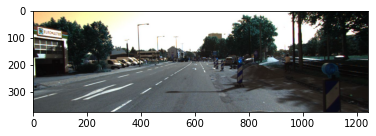

In [ ]:
# Sample data
img = mmcv.imread('kitti_tiny/training/image_2/000051.jpeg')
plt.imshow(img)

### kitti dataset class

In [ ]:
@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpeg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

### Modify the config

In [ ]:
#--------------------------------------
# Modify dataset type and path
#--------------------------------------
cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = 'kitti_tiny/'
cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image_2'
cfg.data.test.pipeline=cfg.test_pipeline
cfg.data.train.type = 'KittiTinyDataset'
cfg.data.train.data_root = 'kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'
cfg.data.test.pipeline=cfg.train_pipeline
cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

#--------------------------------------
# Only 3 classes 
# The follopwing line is specific per detector
#--------------------------------------
cfg.model.bbox_head.num_classes = 3
#--------------------------------------

#--------------------------------------
# Samples and workers per gpu = 1
#--------------------------------------
cfg.data.samples_per_gpu=1
cfg.data.workers_per_gpu=1
#--------------------------------------

#--------------------------------------
# No pretrained chechpoint to load 
#--------------------------------------
cfg.load_from=None
#--------------------------------------

#--------------------------------------
# Set up working dir to save files and logs.
#--------------------------------------
cfg.work_dir = './tutorial_exps'
#--------------------------------------

#--------------------------------------
# learning rate (LR)
#--------------------------------------
cfg.optimizer.lr = 0.0001
#--------------------------------------

#--------------------------------------
# Training 
#--------------------------------------
cfg.runner.max_epochs = 15
cfg.lr_config.warmup = None
cfg.log_config.interval = 10
# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 15
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 15
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

### Fine tune the model on the custom dataset

In [ ]:
# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# train (few epochs just for test)
train_detector(model, datasets, cfg, distributed=False, validate=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int`

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 15.1 task/s, elapsed: 2s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-20 18:30:55,644 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 2175 | 0.177  | 0.002 |
| Pedestrian | 13  | 23   | 0.000  | 0.000 |
| Cyclist    | 7   | 4    | 0.000  | 0.000 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.001 |
+------------+-----+------+--------+-------+
2022-02-20 18:30:55,647 - mmdet - INFO - Epoch(val) [15][25]	AP50: 0.0010, mAP: 0.0006


See how the loss is decreasing without errors 